# Heat equation
The basic one dimensional normalized heat equation has the form
$$
U_t = U_{xx}
$$
where subscripts denote derivatives with respect to either time $t$ or position $x$. Let's suppose we know the value of $U$ at the boundaries (thus, we have Dirichley boundary conditions), such that
$$
U(0,t) = U(\pi,t) = 0
$$
and some initial value for the function in position space
$$
U(x,0) = U_0(x)\,.
$$
We can employ a variety of methods to solve for $U(x,t)$ at all times and positions.

For now, let's work with a problem for which we know the answer. Let's look at the system where $U(0,t) = U(\pi,t) = 0$, which has the solution $U(x,t) = e^{-t}\sin(x)$.

## Finite difference methods
Finite difference methods discretize the function over grids in time (subscript $n$) and space (subscript $j$). From here on, let's suppose that time steps are given by $k$ and spatial steps by $h$, with $r = k/h^2$.

### 1. Explicit forward difference
This method calculates
$$
\frac{u^{n+1}_j - u^n_j}{k} = \frac{u_{j+1}^{n} - 2u_j^{n} + u_{j-1}^{n}}{h^2}\,.
$$
Solving, we find that 
$$
u^{n+1}_j = (1-2r)u_j^{n} + r(u_{j-1}^n + u_{j+1}^n)\,.
$$
Let's try to implement this!

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d #for wireframes
%matplotlib inline
from scipy.sparse import diags #will need this for later examples

In [2]:
#Set up the problem.
Nx = 70
Nt = 1000
x = np.linspace(0.,np.pi,Nx) #positions
t = np.linspace(0.,1.,Nt) #times
U = np.zeros((Nt, Nx))  #the function

In [3]:
#Time steps
k = t[1] - t[0]
h = x[1] - x[0]
r = k/h**2
print "r = %.2e"%r
#Note: we require r <= 1/2 for this to work properly

r = 4.83e-01


In [4]:
#True answer
exp_nt = np.exp(-t)
sin_x  = np.sin(x)
U_true = np.outer(exp_nt, sin_x)

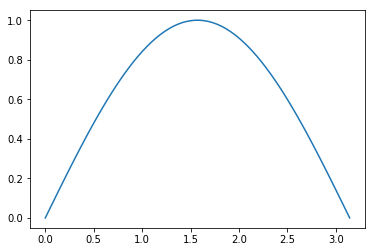

In [5]:
#Set the initial value of the function, U_0 = U(x,0)
U[0,:] = np.sin(x)
#Note: using np.zeros means the boundary conditions are already set,
#but let's do it explicitely to be clear.
#Note: first index is time, second index is position.
U[:,0]  = 0 #U(0,t) = 0
U[:,-1] = 0 #U(pi,t) = 0
plt.plot(x, U[0])

In [6]:
#Loop over times and solve for U(x,t)
for n in range(1,Nt):
    for j in range(1,Nx-1):
        U[n,j] = (1-2.*r)*U[n-1,j] + r*(U[n-1,j-1] + U[n-1,j+1])
        continue
    continue

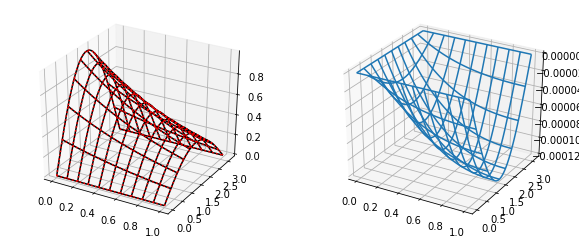

In [7]:
#Plot with wireframes
fig = plt.figure(figsize=plt.figaspect(0.4))
ax = fig.add_subplot(1, 2, 1, projection='3d')
T, X = np.meshgrid(t, x)
ax.plot_wireframe(T, X, U_true.T, rcount=10, ccount=10, color='k')
ax.plot_wireframe(T, X, U.T, rcount=10, ccount=10, color='r', linestyle=':')

D = U - U_true
ax2 = fig.add_subplot(1,2,2, projection='3d')
ax2.plot_wireframe(T, X, D.T, rcount=10, ccount=10)

## 2. Implicit method
The basic implicit method is based on the backwards finite difference, or taking the taylor expansion *backwards* in time rather than forwards. In other words, we can write
$$
\frac{u^{n+1}_j - u^n_j}{k} = \frac{u_{j+1}^{n+1} - 2u_j^{n+1} + u_{j-1}^{n+1}}{h^2}\,.
$$
which gives us a solution for three points at time $t_{n+1}$ as
$$
(1+2r)u_j^{n+1} - ru_{j-1}^{n+1} - ru_{j+1}^{n+1} = u_j^n\,.
$$
This means that to solve for $U(x,t_{n+1})$, one needs to solve a system of linear equations. As with any implicit solver, it is best solved with matrices. In the above equation, we see that we have a matrix equation that looks like
\begin{equation}
\begin{bmatrix}
1 & 0 & 0 & 0 & \dots \\
-r & 1+2r & -r & 0 & \dots \\
0 & -r & 1+2r & -r & \dots \\
\vdots & & & \ddots
\end{bmatrix}
\begin{pmatrix}
u_{0}^{n+1} \\
u_{1}^{n+1} \\
u_{2}^{n+1} \\
\vdots
\end{pmatrix} = \begin{pmatrix}
u_{0}^{n} \\
u_{1}^{n} \\
u_{2}^{n} \\
\vdots
\end{pmatrix}
\end{equation}
We know the right hand side, and if we call the matrix on the left hand side $A$, we can invert it and multiply it through to solve for the vector of $u^{n+1}$ values.

In [8]:
#Set the initial value of the function, U_0 = U(x,0)
#Note: first index is time, second index is position.
U = np.zeros((Nt, Nx))  #the function
U[0,:] = np.sin(x)
U[:,0]  = 0 #U(0,t) = 0
U[:,-1] = 0 #U(pi,t) = 0

In [9]:
#Construct the matrix from the scipy.sparse toolkit
diagonals = [-r, 1+2*r, -r]
offsets = [-1,0,1]
A = diags(diagonals, offsets, shape=(Nx, Nx)).toarray()
#Correctly format the edges to account for the boundary conditions
A[0,0] = A[-1,-1] = 1
A[0,1:] = 0
A[-1, :-1] = 0
A_inv = np.linalg.inv(A)

In [10]:
#Loop over the time steps
for n in range(1,Nt):
    U[n] = np.dot(A_inv, U[n-1])

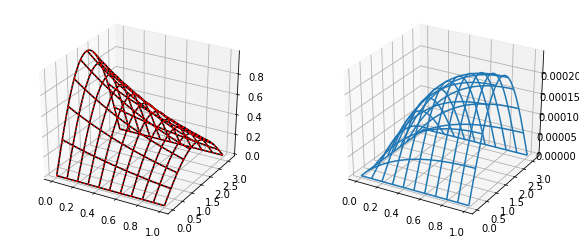

In [11]:
#Plot with wireframes
fig = plt.figure(figsize=plt.figaspect(0.4))
ax = fig.add_subplot(1, 2, 1, projection='3d')
T, X = np.meshgrid(t, x)
ax.plot_wireframe(T, X, U_true.T, rcount=10, ccount=10, color='k')
ax.plot_wireframe(T, X, U.T, rcount=10, ccount=10, color='r', linestyle=':')

D = U - U_true
ax2 = fig.add_subplot(1,2,2, projection='3d')
ax2.plot_wireframe(T, X, D.T, rcount=10, ccount=10)

## 3. Crank-Nicolson method
The forward and backward finite difference can be combined to yield the central difference, which is an average of the finite differences in either direction.
$$
\frac{u^{n+1}_j - u^n_j}{k} = \frac{1}{2}\left(\frac{u_{j+1}^{n+1} - 2u_j^{n+1} + u_{j-1}^{n+1}}{h^2} + \frac{u_{j+1}^{n} - 2u_j^{n} + u_{j-1}^{n}}{h^2}\right)\,.
$$
This yields a new estimate for the values of $u^{n+1}$:
$$
(2+2r)u_j^{n+1} - ru_{j-1}^{n+1} - ru_{j+1}^{n+1} = (2-2r)u_j^n + r(u_{j+1}^{n}+u_{j-1}^{n})\,.
$$
In matrix form, this looks like
$$
AU^{n+1} = BU^n\,.
$$
The right hand side is known entirely, so we can invert $A$, and multiply it onto $BU^n$.

In [12]:
#Set the initial value of the function, U_0 = U(x,0)
#Note: first index is time, second index is position.
U = np.zeros((Nt, Nx))  #the function
U[0,:] = np.sin(x)
U[:,0]  = 0 #U(0,t) = 0
U[:,-1] = 0 #U(pi,t) = 0

In [13]:
#Construct the matrix from the scipy.sparse toolkit
diagonals = [-r, 2+2*r, -r]
offsets = [-1,0,1]
A = diags(diagonals, offsets, shape=(Nx, Nx)).toarray()
#Correctly format the edges to account for the boundary conditions
A[0,0] = A[-1,-1] = 1
A[0,1:] = A[1:,0] = 0
A[-1, :-1] = A[:-1, -1] = 0
A_inv = np.linalg.inv(A)

B_diagonals = [r, 2-2*r, r]
offests = [-1,0,1]
B = diags(B_diagonals, offsets, shape=(Nx, Nx)).toarray()
#Correctly format the edges to account for the boundary conditions
B[0,0] = B[-1,-1] = 1
B[0,1:] = B[-1,:-1] = 0

In [14]:
#Loop over the time steps
for n in range(1,Nt):
    U[n] = np.dot(A_inv, np.dot(B,U[n-1]))

r = 4.828730e-01


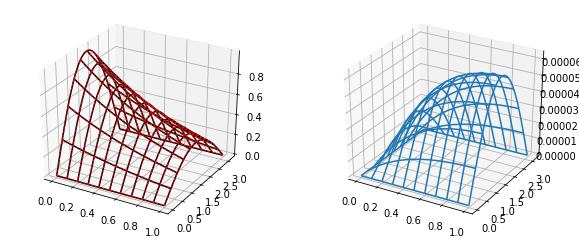

In [15]:
#Plot with wireframes
fig = plt.figure(figsize=plt.figaspect(0.4))
ax = fig.add_subplot(1, 2, 1, projection='3d')
T, X = np.meshgrid(t, x)
ax.plot_wireframe(T, X, U_true.T, rcount=10, ccount=10, color='k')
ax.plot_wireframe(T, X, U.T, rcount=10, ccount=10, color='r', linestyle=':')

D = U - U_true
ax2 = fig.add_subplot(1,2,2, projection='3d')
ax2.plot_wireframe(T, X, D.T, rcount=10, ccount=10)
print "r = %e"%r

### Best method
If you pay attention to the scale on the right side figures that show the difference between the true and calculated answer, you will notices that depending on what the value of $r$ is, the best method will change. In general, if $r$ is very small, then the explicit method might be best. For large values of $r$ (or for this notebook, if *Nx* gets closer to *Ny*) then the Crank-Nicolson becomes much better. The hard part about CN is that it requires an O(N^3) matrix inversion as written. However, since in the case of PDE solvers this is usually a tridiagonal or something similar, one can use fancy matrices to reduce this to O(N).

## 3.5 Tridiagonal algorithm for CN
Tridiagonal matrix backsubstitution problems can be solved in O(N) time. If we have a matrix equation of the form $Ax = d$, with the matrix $A$ containing a lower, middle, and upper diagonal containing elements $a,b,c$ (with $a_0=c_{n}=0$), then the tridiagonal algorithm is [linked here](https://en.wikipedia.org/wiki/Tridiagonal_matrix_algorithm).

In [19]:
#Set the initial value of the function, U_0 = U(x,0)
#Note: first index is time, second index is position.
U = np.zeros((Nt, Nx))  #the function
U[0,:] = np.sin(x)
U[:,0]  = 0 #U(0,t) = 0
U[:,-1] = 0 #U(pi,t) = 0

In [21]:
#Create the arrays to hold a,b,c
diagonals = [-r, 2+2*r, -r] #a,b,c values
a = np.ones(Nx) * diagonals[0]
a[0] = a[-1] = 0 #a[0] is off the "edge" and a[-1] is set by the boundary condition
b = np.ones(Nx) * diagonals[1]
b[0] = b[-1] = 1 #boundary conditions
c = np.ones(Nx) * diagonals[2]
c[0] = c[-1] = 0 #c[0] is set by the boundary conditions and c[-1] is off the "edge"
#Using wikipedia's notation, the new variables will be 'primed'. Here I'll use a trailing _
c_ = np.ones_like(c)
d_ = np.ones_like(d)
#We can precompute the c_ array, since it only depends on the A matrix (a,b,c)
c_[0] = c[0]/b[0]
for i in range(1,Nx):
    c_[i] = c[i]/(b[i]-a[i]*c_[i-1])

In [22]:
#Loop over time steps to solve for the next time
for n in range(1,Nt):
    #Start by creating the right side: d = BU^0
    d = np.dot(B, U[n-1])
    d_[0] = d[0]/b[0]
    for i in range(1,Nx):
        d_[i] = (d[i]-a[i]*d_[i-1])/(b[i]-a[i]*c_[i-1])
    #Now do back substitution
    U[n,-1] = d_[-1]
    for i in range(Nx-2, -1, -1): #Back substitution
        U[n,i] = d_[i] - c_[i]*U[n,i+1]

r = 4.828730e-01


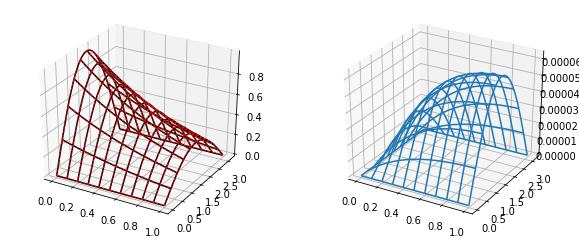

In [23]:
#Plot with wireframes
fig = plt.figure(figsize=plt.figaspect(0.4))
ax = fig.add_subplot(1, 2, 1, projection='3d')
T, X = np.meshgrid(t, x)
ax.plot_wireframe(T, X, U_true.T, rcount=10, ccount=10, color='k')
ax.plot_wireframe(T, X, U.T, rcount=10, ccount=10, color='r', linestyle=':')

D = U - U_true
ax2 = fig.add_subplot(1,2,2, projection='3d')
ax2.plot_wireframe(T, X, D.T, rcount=10, ccount=10)
print "r = %e"%r

### Woo hoo!